In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

2.5.0


In [2]:
# Load the data
column_names = ['id','date','price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated', 'zipcode','lat','long','sqft_living15','sqft_lot15']

raw_dataset = pd.read_csv('./data/kc_house_data.csv', names=column_names,
                          na_values='?',
                          header = 1,
                          sep=',', skipinitialspace=False)
raw_dataset = raw_dataset.drop(columns = ['id', 'date']) # 'lat', 'long', 'zipcode'
dataset = raw_dataset.copy()
dataset.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


In [3]:
dataset = dataset.dropna()

In [4]:
# Split data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

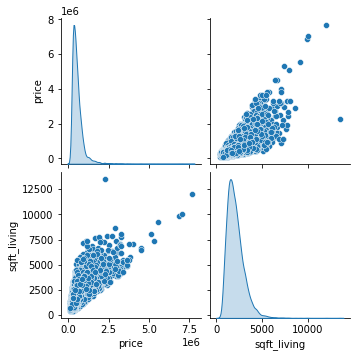

In [5]:
sns.pairplot(train_dataset[['price','sqft_living']], diag_kind='kde')

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,17290.0,541517.092886,369526.912420,78000.0000,322250.000000,450000.0000,645000.0000,7.700000e+06
bedrooms,17290.0,3.367322,0.936473,0.0000,3.000000,3.0000,4.0000,3.300000e+01
bathrooms,17290.0,2.115602,0.770501,0.0000,1.750000,2.2500,2.5000,8.000000e+00
sqft_living,17290.0,2081.741700,925.247712,370.0000,1420.000000,1910.0000,2550.0000,1.354000e+04
sqft_lot,17290.0,14979.650954,39763.616414,520.0000,5050.000000,7641.5000,10715.5000,1.651359e+06
floors,17290.0,1.494014,0.540490,1.0000,1.000000,1.5000,2.0000,3.500000e+00
waterfront,17290.0,0.008039,0.089304,0.0000,0.000000,0.0000,0.0000,1.000000e+00
view,17290.0,0.238809,0.775103,0.0000,0.000000,0.0000,0.0000,4.000000e+00
condition,17290.0,3.410816,0.653212,1.0000,3.000000,3.0000,4.0000,5.000000e+00
grade,17290.0,7.660555,1.183123,3.0000,7.000000,7.0000,8.0000,1.300000e+01


In [7]:
# Separate features from the predicted variable
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

In [8]:
test_results = {}

In [33]:
selected_features = ['sqft_living', 'sqft_lot', 'bedrooms','bathrooms', 'view', 'condition', 'grade']
np_selected_features = np.array(train_features[selected_features])
normalizer = preprocessing.Normalization(input_shape=[7,])
normalizer.adapt(np_selected_features)
model = tf.keras.Sequential([
    normalizer,
    # layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 7)                 15        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 592
Trainable params: 577
Non-trainable params: 15
_________________________________________________________________


In [36]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')
history = model.fit(
    train_features[selected_features], train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2)
#%
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Epoch 1/100
433/433 [==============================] - 1s 820us/step - loss: 402914.7500 - val_loss: 222231.0625
Epoch 2/100
433/433 [==============================] - 0s 654us/step - loss: 181299.4375 - val_loss: 168430.2812
Epoch 3/100
433/433 [==============================] - 0s 888us/step - loss: 156422.5625 - val_loss: 153234.2656

,loss,val_loss,epoch
95,135395.218750,137337.843750,95
96,135368.515625,137455.734375,96
97,135302.984375,137423.562500,97
98,135254.062500,137210.390625,98
99,135308.609375,137350.500000,99


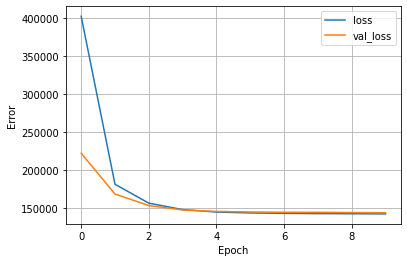

In [37]:
def plot_loss(history):
  plt.plot(history.history['loss'][:10], label='loss')
  plt.plot(history.history['val_loss'][:10], label='val_loss')
  plt.xlabel('Epoch')

  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [38]:
test_results[str(selected_features) + "-model"] = model.evaluate(
    test_features[selected_features],
    test_labels, verbose=0)

In [39]:
test_mae = model.evaluate(
    test_features[selected_features],
    test_labels, verbose=True)

print(f"Test MAE is {test_mae}")

136/136 [==============================] - 0s 956us/step - loss: 135217.1562
Test MAE is 135217.15625


In [40]:
test_results

{"['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'view', 'condition', 'grade']-model": 135217.15625}

In [41]:
preds = model.predict(test_features[selected_features])
mae_err = 0
test_labels_np = test_labels.to_numpy()
for i in range(preds.shape[0]):
    mae_err += abs(preds[i] - test_labels_np[i])
mae_err /= preds.shape[0]
mae_err

array([135217.], dtype=float32)